## Step #1 : Camera Calibration ✅

We will first determine the intrinsic parameters of our cameras and their relative positions.

Camera Calibration using chessboard left images:

chessboards\c1Left.png


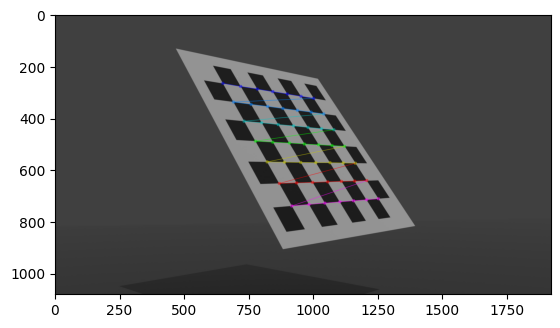

chessboards\c2Left.png


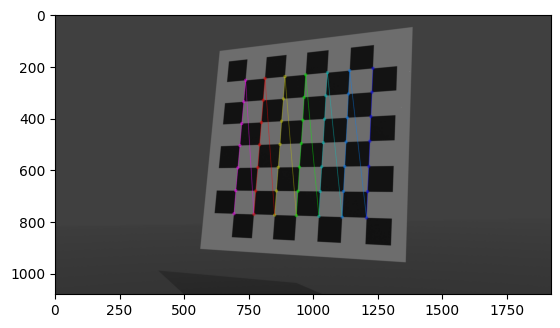

chessboards\c3Left.png


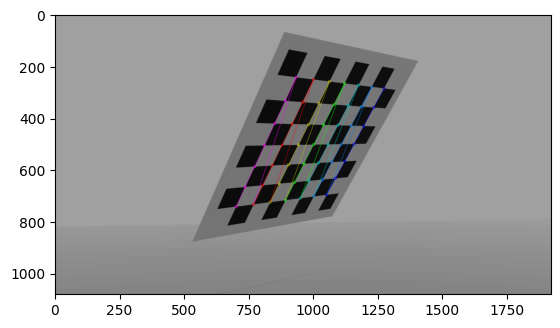

chessboards\c4Left.png


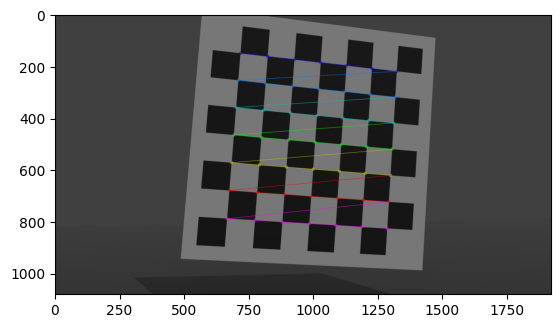

Camera Calibration using chessboard right images:

chessboards\c1Right.png


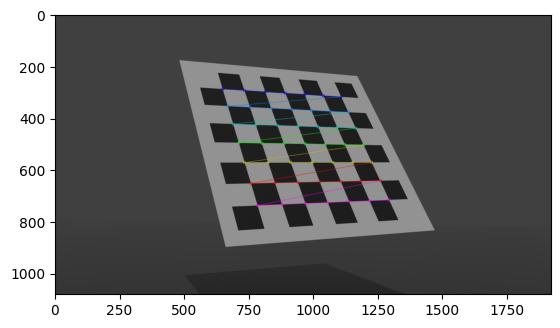

chessboards\c2Right.png


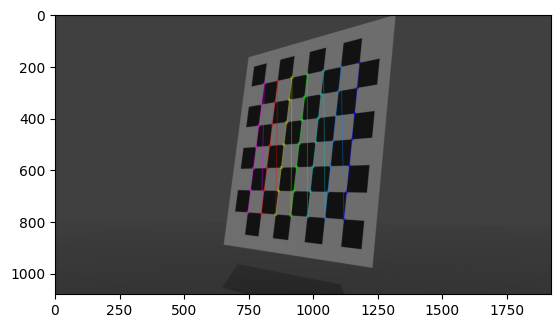

chessboards\c3Right.png


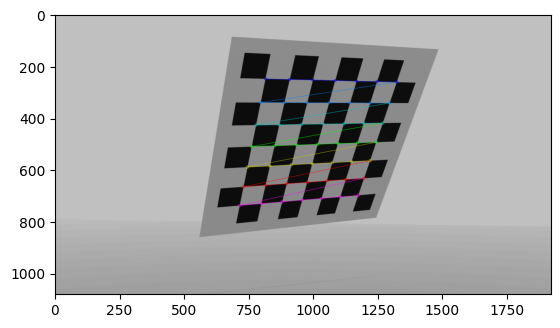

chessboards\c4Right.png


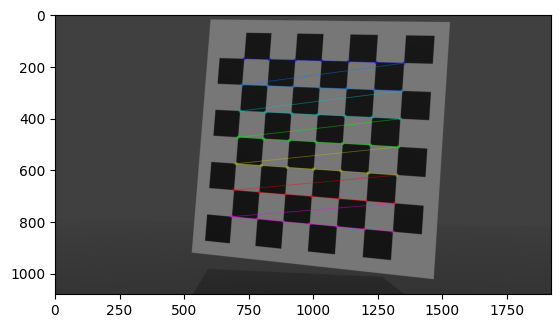

In [11]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calibrate_camera(images, chessboard_size):
    obj_points = []  # 3D points in real-world space
    img_points = []  # 2D points in image plane
    
    # Prepare object points: (0,0,0), (1,0,0), ..., (chessboard_size[0]-1, chessboard_size[1]-1, 0)
    objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
    
    image_size = (1920,1080)  # To store the size of the images
    
    # Process each image
    for file in images:
        img = cv2.imread(file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, chessboard_size)
        if ret:
            img_points.append(corners)
            obj_points.append(objp)
            # termination criteria for the cornerSubPix algorithm
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            # Optionally refine corners
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, chessboard_size, corners2, ret)
            print(file)
            plt.imshow(img)
            plt.show()
    
    # Calibrate the camera
    ret, cameraMatrix, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, image_size, None, None)
    return ret, cameraMatrix, dist, rvecs, tvecs, img_points

# Images location
left_images = sorted(glob.glob('chessboards/*Left.png'))
right_images = sorted(glob.glob('chessboards/*Right.png'))

chessboard_size = (7, 7) # Pour un chéquier 8x8 car on spécifie le nombre de coins intérieurs

# CAMERA CALIBRATION
print("Camera Calibration using chessboard left images:\n")
retL, cameraMatrixL, distL, rvecsL, tvecsL, imagePointsL  = calibrate_camera(left_images, chessboard_size)
print("Camera Calibration using chessboard right images:\n")
retR, cameraMatrixR, distR, rvecsR, tvecsR, imagePointsR = calibrate_camera(right_images, chessboard_size)

## Step #2 : Projection Matrices ✅

Next we need to compute the cameras' projection matrices.

In [2]:
def get_projection_matrix(cameraMatrix, rvecs, tvecs):
    R, _ = cv2.Rodrigues(rvecs) # Convert rotation vector to matrix
    extrinsic_matrix = np.hstack((R, tvecs)) # Combine rotation and translation
    return np.dot(cameraMatrix, extrinsic_matrix)

# Projection matrices
projMatL = get_projection_matrix(cameraMatrixL, rvecsL[0], tvecsL[0])
projMatR = get_projection_matrix(cameraMatrixR, rvecsR[0], tvecsR[0])

print("Projection matrices: \n", projMatL)
print("\n", projMatR)

Projection matrices: 
 [[ 2.06355251e+03  6.06547854e+02 -8.39946715e+02  1.42330411e+04]
 [ 4.65096927e+02  1.43122504e+03  1.56046499e+03  5.87111372e+03]
 [ 7.79216216e-01 -4.01567940e-01  4.81212301e-01  2.19552228e+01]]

 [[ 2.30350682e+03  8.88640312e+01 -1.31769650e+02  1.50558761e+04]
 [ 2.70172867e+02  1.33214469e+03  1.68929698e+03  6.71755030e+03]
 [ 4.77041606e-01 -5.55333433e-01  6.81201941e-01  2.32615876e+01]]


## Step #3 : Fundamental Matrix ✅

Compute fundamental matrix.

In [12]:
def compute_fundamental_matrix(img_points_left, img_points_right):
    
    pts_left = np.array([pt.ravel() for pts in img_points_left for pt in pts])
    pts_right = np.array([pt.ravel() for pts in img_points_right for pt in pts])
    
    # Compute the fundamental matrix using matched points from the left and right images.
    F, mask = cv2.findFundamentalMat(pts_left, pts_right, method=cv2.FM_RANSAC)
    return F, mask
    
# retL, cameraMatrixL, distL, rvecsL, tvecsL  = calibrate_camera(left_images, chessboard_size)
F, mask = compute_fundamental_matrix(imagePointsL, imagePointsR)

print("Fundamental Matrix:\n", F)

Fundamental Matrix:
 [[ 4.07852709e-10  7.84673364e-07 -5.09025990e-04]
 [ 8.45744105e-07 -1.05274404e-08 -9.32221537e-03]
 [-5.44381768e-04  7.78379820e-03  1.00000000e+00]]


## Step #4 : Red Lines Sampling ✅/❌

The red lines are sampled for the pairing process.

In [13]:
'''Get all red pixels from the image'''
def getRed(fname):
    img = cv2.imread(fname)
    #acces only R channel from BGR
    red = img[:,:,2]
    #keep only pixels between 127 and 255 in the red channel
    ret, mask = cv2.threshold(red,127,255,cv2.THRESH_TOZERO)
    return mask

'''Find epilines on right image of all given red points of left image'''
def getEpiLine(F,points):
    return F @ points
    
'''returns epilines (on right camera image) for all red points of the red line (of the left camera), from all images'''
def findEpilines(path):
    epilines = []
    
    for l in range(26):
        #correct format to match file name
        if l<10:
            strp = path + '000' + str(l) +'.png'
        else:
            strp = path + '00' + str(l) +'.png'
            
        #get the red mask    
        red = getRed(strp)
        tempEpilines = []
        pointsLeft = [[],[],[]]
        
        #i is the number of the line
        for i, line in enumerate(red):
            for pixel in line:
                if pixel != 0:
                    pixel = 1
            try:
                #weighted average => (0*0 + 1*0 + 2*0 + ... + 1248 * 1 + 1249 * 0) / n° of red pixels
                #for instance => (1261+1262+1267)/3 = 1263.33
                #give position of the red line in x axis
                pointsLeft[0].append(np.average(range(1920), weights = line))
                pointsLeft[1].append(i) # y axis
                pointsLeft[2].append(1)
            except:
                pass
        #from red line on left image, find corresponding epiline on right image
        epilinesRight = getEpiLine(F, pointsLeft)
        tempEpilines.append(pointsLeft)
        
        tempEpilines.append(epilinesRight)
        epilines.append(tempEpilines)
    return epilines

# epl = [ [ [Red_x_avg], [Y_avg], [1] ], [EpilineRight(i)] ] ]
epl = findEpilines('scanLeft/')
print ('epipiline : ',epl)

epipiline :  [[[[], [], []], array([], shape=(3, 0), dtype=float64)], [[[], [], []], array([], shape=(3, 0), dtype=float64)], [[[], [], []], array([], shape=(3, 0), dtype=float64)], [[[np.float64(1374.0), np.float64(1374.4176829268292), np.float64(1374.5752688172042), np.float64(1375.421836228288), np.float64(1375.524336283186), np.float64(1376.0158478605388), np.float64(1376.1365777080064), np.float64(1376.9183976261127), np.float64(1377.008486562942), np.float64(1377.3849821215733), np.float64(1377.5252873563218), np.float64(1377.633867276888), np.float64(1378.0040871934605), np.float64(1378.3838383838383), np.float64(1378.4704595185995), np.float64(1378.5434782608695), np.float64(1378.6061269146608), np.float64(1378.980824544583), np.float64(1379.0878701050622), np.float64(1379.440170940171), np.float64(1379.4968220338983), np.float64(1379.541798941799), np.float64(1379.58315565032), np.float64(1379.9592215013902), np.float64(1380.0414364640883), np.float64(1380.1147086031453), np.f

## Step #5 : Epipolar Lines ✅/❌

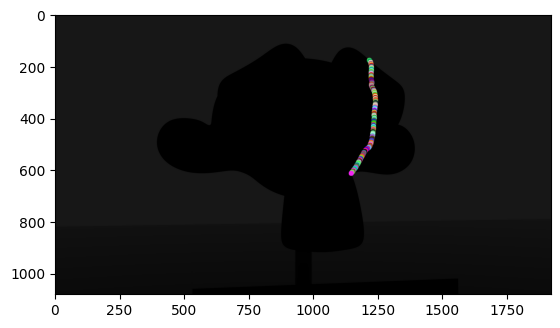

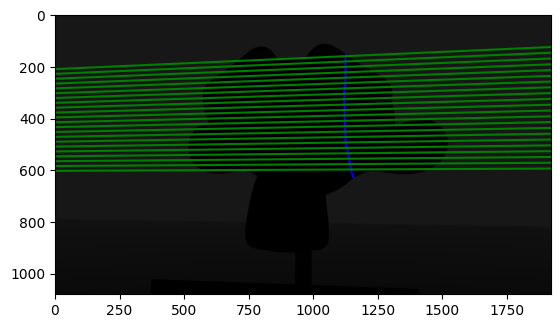

In [23]:
def drawAvgPoint(fname,EplLeft):
    img = cv2.imread(fname)
    i = 0
    while i < len(EplLeft[0]):
        color = tuple(np.random.randint(0,255,3).tolist())
        img = cv2.circle(img,(int(EplLeft[0][i]),int(EplLeft[1][i])),10,color,-1)
        i += 4
    plt.imshow(img)
    plt.show()

'''equation of a ligne => returns a value for y for a given x and coefficients'''
def lineY(coefs,x):
    a,b,c = coefs
    return-(c+a*x)/b


def drawEpl(fname,EplRight):
    img = cv2.imread(fname)
    coef , length = EplRight.shape
    for i in range(0,length,20):
        #print a, b and c of epiline
        #print(EplRight[:,i])
        plt.plot([0,1919],[lineY(EplRight[:,i],0),lineY(EplRight[:,i],1919)],'g')
        
    plt.imshow(img)
    plt.show()

drawAvgPoint('scanLeft/0010.png',epl[10][0])
drawEpl('scanRight/scan0010.png',epl[10][1])

## Step #6 : Matching Pairs ✅/❌

## Step #7 : Triangulated 3D points ✅/❌